# Global validation for Windsat model v1

Load the pre-trained models   

Load validation data 

Plot global maps, get variable importance

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from matplotlib.colors import CenteredNorm, LinearSegmentedColormap
from tensorflow.keras.models import load_model

from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

from scipy.stats import kstest

import xarray as xr
import pandas as pd
import numpy as np
import pickle
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '../..')))

from src.processing import windsat_datacube, model_preprocess, telsem_datacube, doy2month_mapping
from src.model import plot_history, xy_split

# Files
ws_path = "../../data/raw/daily_windsat/"
model_folder = "../../models/"

swath2name = {
    0 : "Asc",
    1 : "Des"
}

(<Figure size 2400x1000 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='log(mse [K²])'>,
        <Axes: title={'center': 'Epochs after loss < 20'}, xlabel='Epoch', ylabel='mse [K²]'>],
       dtype=object))

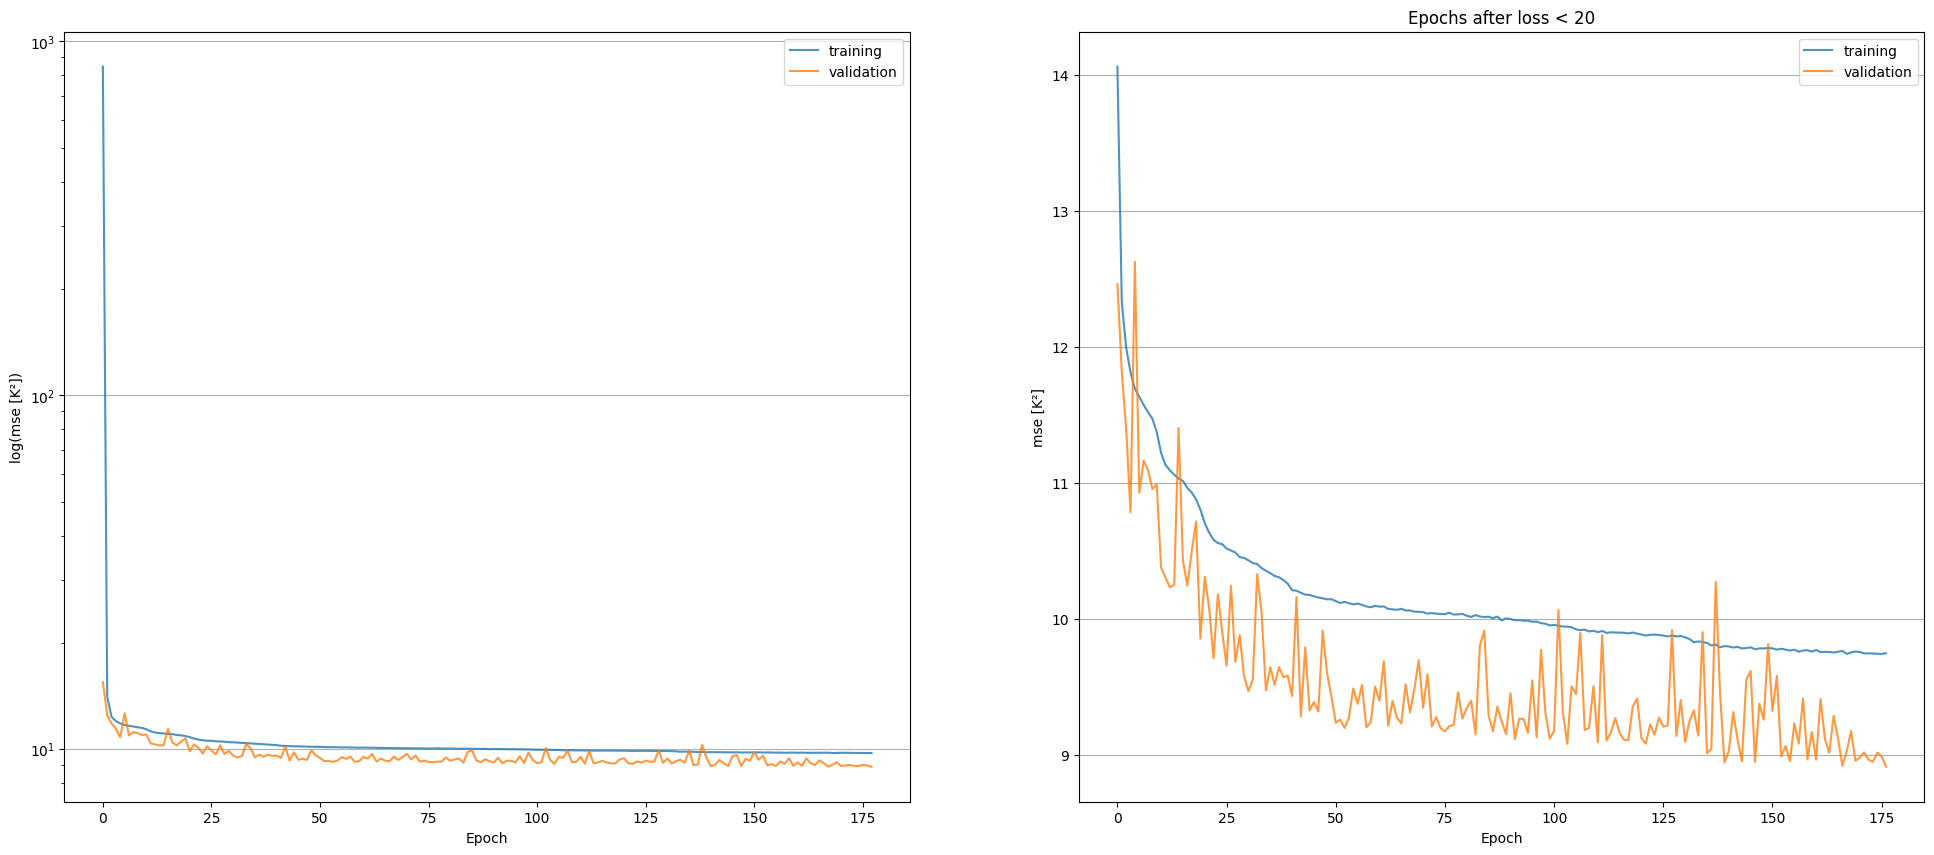

In [4]:
history_path = r"C:\Users\andre\Desktop\VS_Code\PMW_LST\models\WSMv1_A_2024_07_23T135732_history"
with open(history_path, "rb") as file:
    history = pickle.load(file)
plot_history(history, loss_threshold=20)

In [3]:
# Load a model
v2_model_ids = { # Swathid : datestring
    0 : "WSMv2_A_2024_07_23T202640",
    1 : "WSMv2_D_2024_07_23T180208"
}

v2_models = {
    swath : load_model(os.path.join(model_folder,datestring + ".keras")) for swath,datestring in v2_model_ids.items()
}

v2_models[0].summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 60)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,995 (35.14 KB)

 Trainable params: 2,991 (11.68 KB)

 Non-trainable params: 20 (80.00 B)

 Optimizer params: 5,984 (23.38 KB)

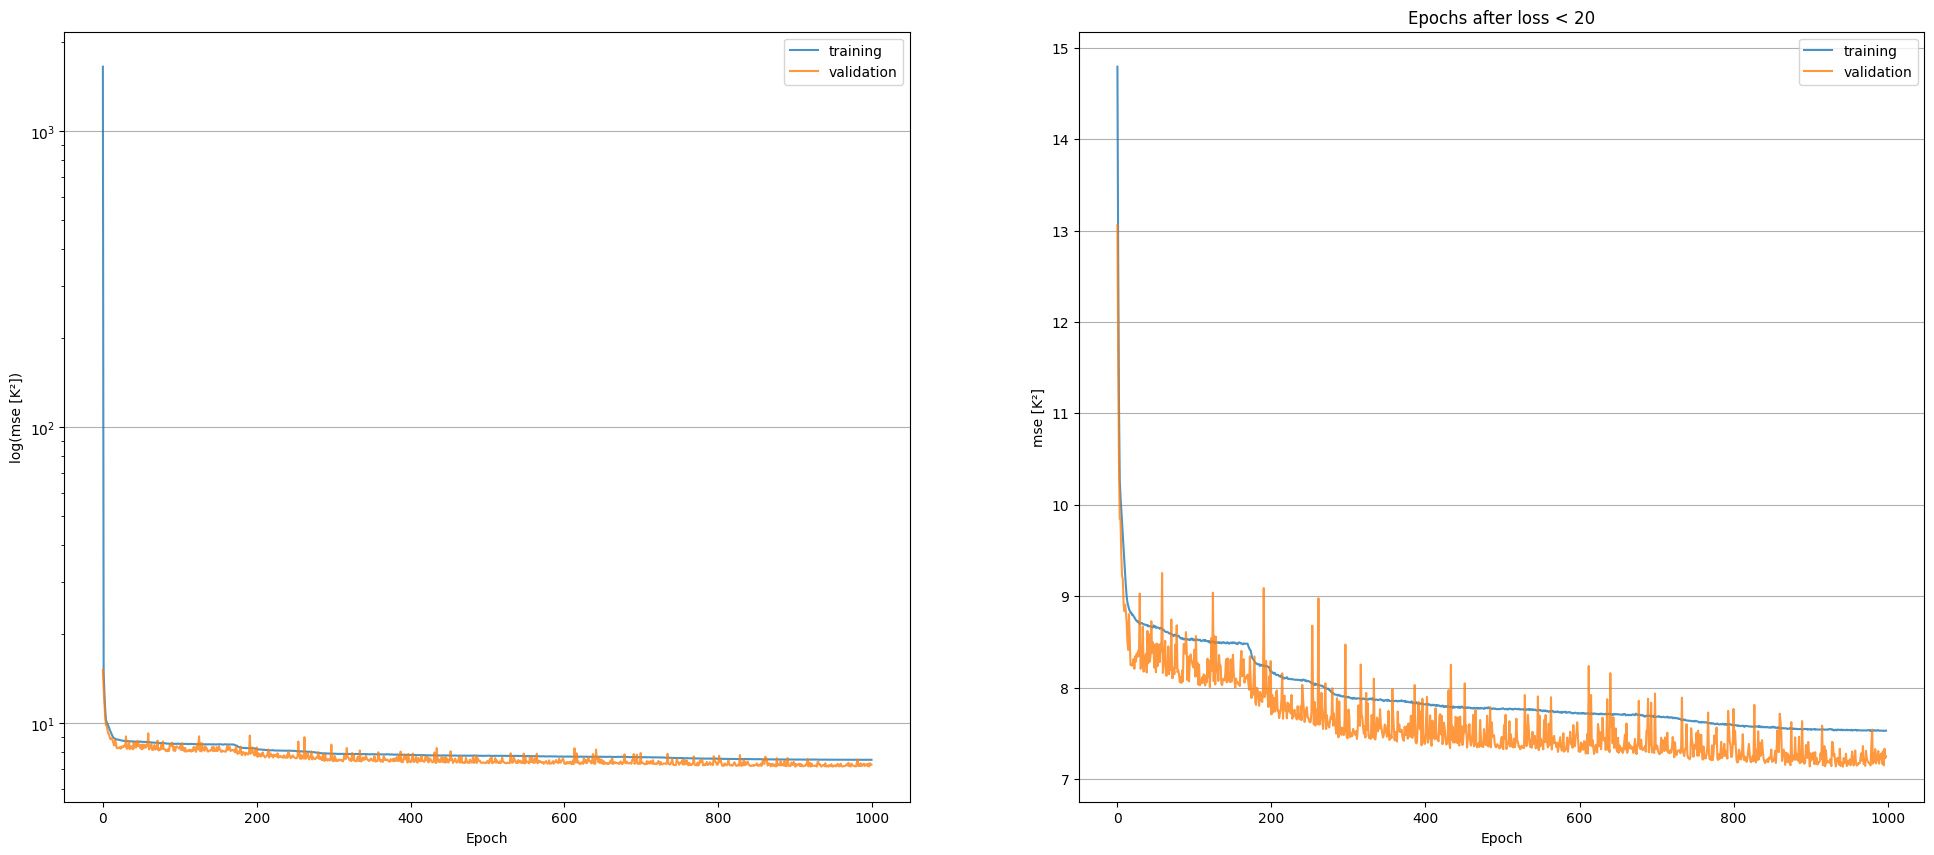

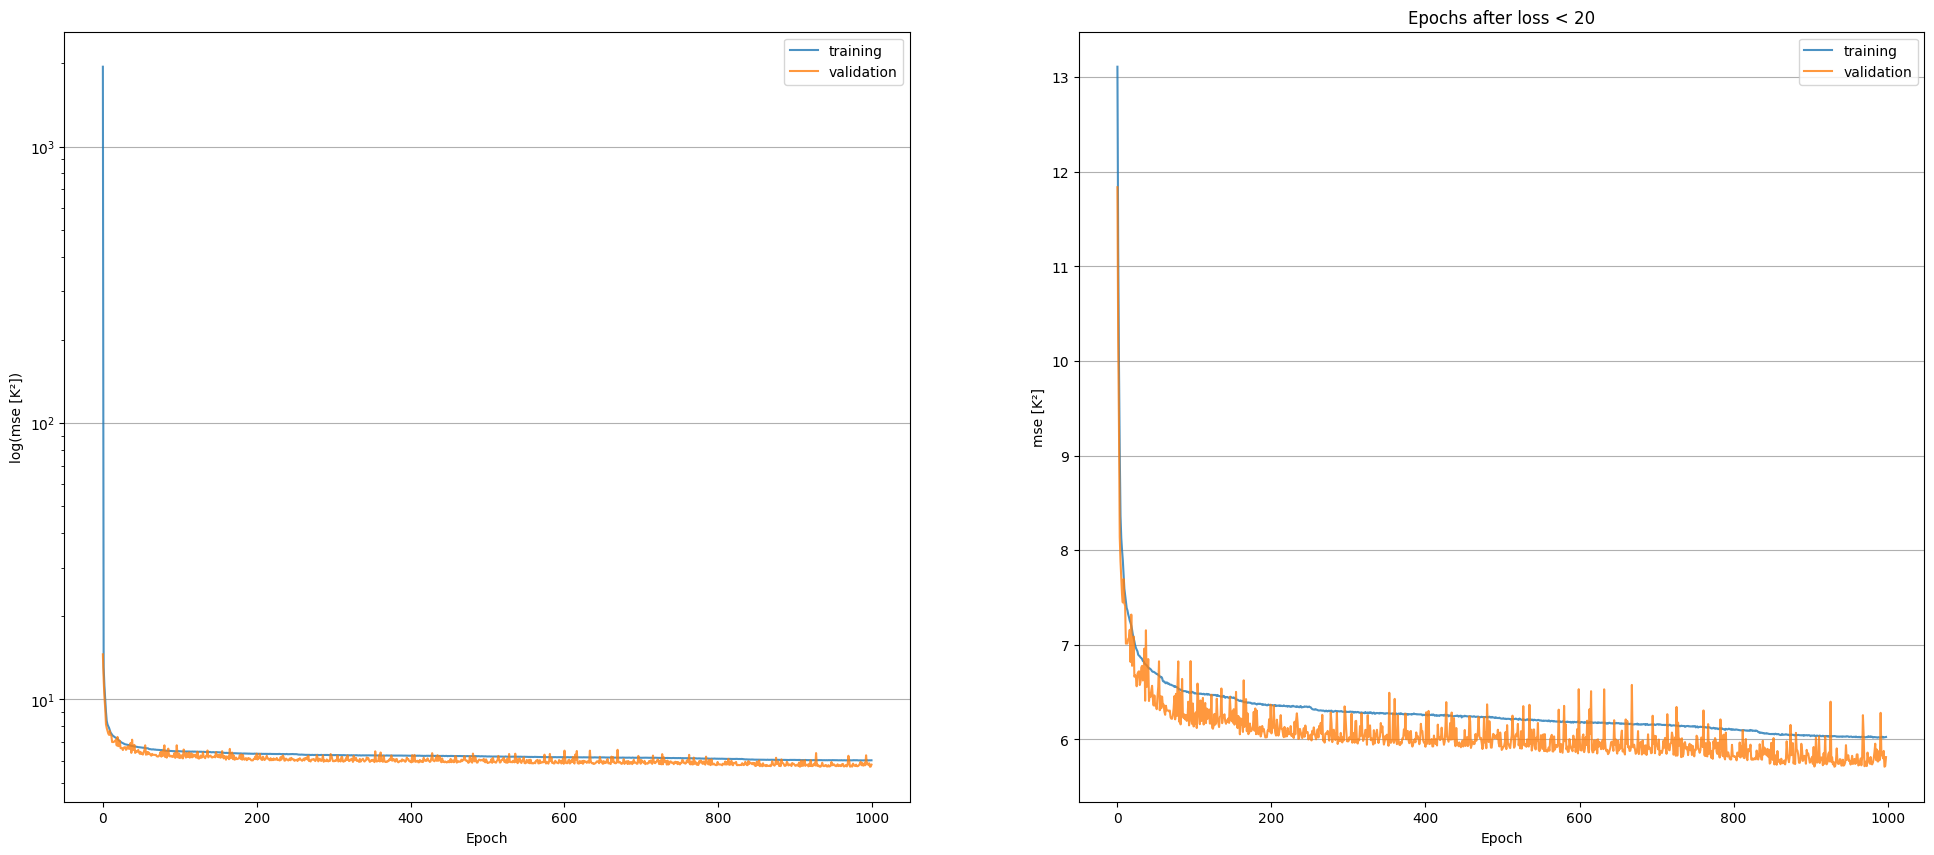

In [4]:
# Load and plot training histories
for swath in [0,1]:
    history_path = os.path.join(model_folder, v2_model_ids[swath] + "_history")

    with open(history_path, "rb") as file:
        history = pickle.load(file)
    plot_history(history, loss_threshold=20)

In [5]:
# Load windsat dataset, and trasnform it to feed it to the model
ds = windsat_datacube(ws_path)
ds

<xarray.Dataset> Size: 6GB
Dimensions:         (day_number: 24, longitude_grid: 1440, latitude_grid: 720,
                     swath_sector: 2, frequency_band: 2, look_direction: 2,
                     polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * day_number      (day_number) int32 96B 1 2 57 58 84 ... 283 323 324 348 349
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, look_direction, polarization
Data variables: (12/13)
    longitude       (day_number, longitude_grid) float32 138kB dask.array<chunksize=(1, 1440), meta=np.ndarray>
    latitude        (day_number, latitude_grid) float32 69kB dask.array<chunksize=(1, 720), meta=np.ndarray>
    node            (day_number, swath_sector) int32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_vpol  (day_number, frequency_band) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_hpol  (day_number, frequency_band) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    eia_nominal     (day_number, frequency_band) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    ...              ...
    eaa             (day_number, frequency_band, latitude_grid, longitude_grid, look_direction, swath_sector) float32 796MB dask.array<chunksize=(1, 1, 360, 720, 1, 1), meta=np.ndarray>
    eia             (day_number, frequency_band, latitude_grid, longitude_grid, look_direction, swath_sector) float32 796MB dask.array<chunksize=(1, 1, 360, 720, 1, 1), meta=np.ndarray>
    tbtoa           (day_number, polarization, frequency_band, latitude_grid, longitude_grid, look_direction, swath_sector) float32 2GB dask.array<chunksize=(1, 1, 1, 240, 480, 1, 1), meta=np.ndarray>
    quality_flag    (day_number, latitude_grid, longitude_grid, look_direction, swath_sector) int32 398MB dask.array<chunksize=(1, 360, 720, 1, 1), meta=np.ndarray>
    surtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 199MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    airtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 199MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [6]:
#TELSEM ATLAS
telsem_folder = r"..\..\data\processed\WindsatEmiss"

# Preprocessing of TELSEM atlas:
telsem_ds = telsem_datacube(telsem_folder)

telsem_df = telsem_ds.to_dataframe().dropna().reset_index("month")


In [8]:
# Plot function

def get_error_maps(swath:int):

    model = v2_models[swath]

    swath_ds= model_preprocess(ds, swath_sector=swath, look="impute",add_look_flag=False)
    swath_df = swath_ds.to_dataframe().dropna().reset_index("day_number")

    day_mapping = doy2month_mapping()
    swath_df["month"] = swath_df["day_number"].apply(lambda x: day_mapping[x])
    # drop the day_number column
    swath_df = swath_df.drop(columns="day_number")

    # Inner join the telsem df and the ascending df
    df = pd.merge(left=swath_df, right=telsem_df, how="inner")

    # Drop the month column
    df = df.drop(columns="month")

    # Save the original lat lon for plotting later
    lat = df["lat"].copy()
    lon = df["lon"].copy()

    df["lon"] = df["lon"].apply(lambda x: np.sin(np.deg2rad(x)))
    df["lat"] = df["lat"].apply(lambda x: np.sin(np.deg2rad(x)))

    # Predict for the local sample:
    X, y = xy_split(df, y_column = "surtep_ERA5")
    df["surtep_MODEL"] = model.predict(X)
    df["error"] = df["surtep_MODEL"] - df["surtep_ERA5"] 

    # Re add lon and lat as they were
    df["lat"] = lat
    df["lon"] = lon

    # Calculate the error per pixel, group by lat and lon
    v2error_df = df[["lat","lon","error"]]
    v2error_df.set_index(keys=["lat","lon"], inplace=True)
    v2error_df = v2error_df.groupby(by=["lat","lon"]).mean()
    v2error_df.reset_index(inplace=True)

    # Stats
    n_obs = len(df)
    rmse = np.sqrt(mean_squared_error(df["surtep_MODEL"],y))

    # Kolmogorov-Smirnov (for a normal distribution)
    mean_error = df["error"].mean()
    std_error = df["error"].std()

    ks_stat, ks_p = kstest(df["error"], 'norm', args=(mean_error, std_error))

    # save all statins into a dataframe row
    stats_df = pd.DataFrame({
        "Swath": swath2name[swath],
        "Model" : "Model v2",
        'Bias [K]': [mean_error],
        'std [K]': [std_error],
        'rmse [K]': [rmse],
        'ks_stat': [ks_stat],
        'p-value': [ks_p],
        'n_obs' : [n_obs]
    })

    # Get permutation importance:
    print("Get variable importance:")
    var_importances = permutation_importance(
    model, X, y,
    scoring="neg_median_absolute_error",
    max_samples= 0.1, # We have a lot of data, use only 10 % 
    n_repeats=3
    )

    # Get te results into a readable table:
    importance = var_importances.importances_mean
    importances ={var:value for var,value in zip(X.columns, importance)}
    
    # Custom error colormap
    color_min    = "#ff0000"
    color_center = "#BBBBBB" 
    color_max    = "#0000FF"

    error_cmap = LinearSegmentedColormap.from_list(
        "cmap_name",
        [color_min, color_center, color_max]
    )

    fig, ax = plt.subplots(1,1,figsize = (14,8), subplot_kw={"projection":ccrs.PlateCarree()} )
    norm = CenteredNorm(vcenter=0,halfrange=10, clip = False)

    ax.coastlines("110m")

    scatter = ax.scatter(
        x = v2error_df["lon"],
        y = v2error_df["lat"],
        s= 0.1,
        alpha = 1,
        c = v2error_df["error"],
        cmap = error_cmap,
        norm=norm
    )

    ax.set_title(f"Model v2: {swath2name[swath]} swath")

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make space for the colorbar

    # Add a common colorbar
    cbar_ax = fig.add_axes([0.15, 0.02, 0.7, 0.02])  # Position: [left, bottom, width, height]
    fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal', label='Mean error per pixel [K]')

    plt.show()

    return fig, ax, stats_df, importances


52364/52364 ━━━━━━━━━━━━━━━━━━━━ 36s 692us/step
Get variable importance:
52364/52364 ━━━━━━━━━━━━━━━━━━━━ 43s 811us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 663us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 659us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 668us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 682us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 669us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 950us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 903us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 771us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 746us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 749us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 772us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 772us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 722us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 748us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 783us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 798us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 863us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 727us/step
5237/5237 ━━━━━━━━━━━━━━━━

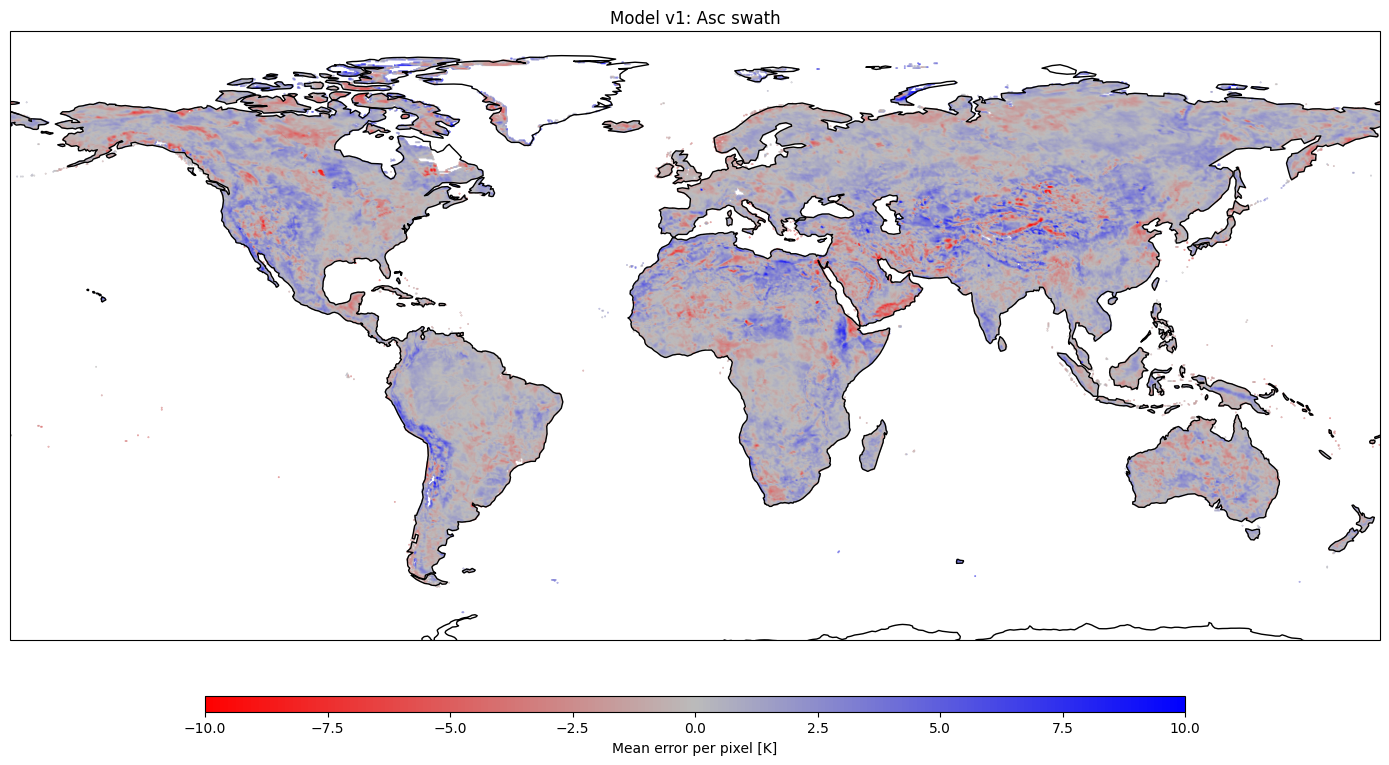

In [9]:
fig, ax, stats_df, importances = get_error_maps(swath = 0)

In [10]:
stats_df

,Swath,Model,Bias [K],std [K],rmse [K],ks_stat,p-value,n_obs
0,Asc,Model v2,0.330157,2.562142,2.583326,0.046954,0.0,1675642


In [11]:
importances_df = pd.DataFrame.from_dict(importances, orient="index", columns=["importance [mse]"])
importances_df["importance % "] = 100 * importances_df["importance [mse]"] / importances_df["importance [mse]"].sum()
importances_df

,importance [mse],importance %
lat,0.778753,3.162853
lon,0.078949,0.320646
tbtoa_18Ghz_V,7.727946,31.386548
tbtoa_18Ghz_H,3.117091,12.659861
tbtoa_37Ghz_V,6.134944,24.916673
tbtoa_37Ghz_H,3.312668,13.454184
Emis19V,0.745819,3.029096
Emis19H,0.570485,2.316989
Emis37V,0.929886,3.776671
Emis37H,1.225301,4.976480


40291/40291 ━━━━━━━━━━━━━━━━━━━━ 38s 939us/step
Get variable importance:
40291/40291 ━━━━━━━━━━━━━━━━━━━━ 39s 976us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 3s 740us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 3s 838us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 3s 841us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 4s 906us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 4s 893us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 4s 874us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 4s 904us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 3s 839us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 3s 820us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 4s 914us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 3s 860us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 3s 843us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 4s 863us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 4s 890us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 3s 775us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 3s 815us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 4s 949us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 4s 972us/step
4029/4029 ━━━━━━━━━━━━━━━━

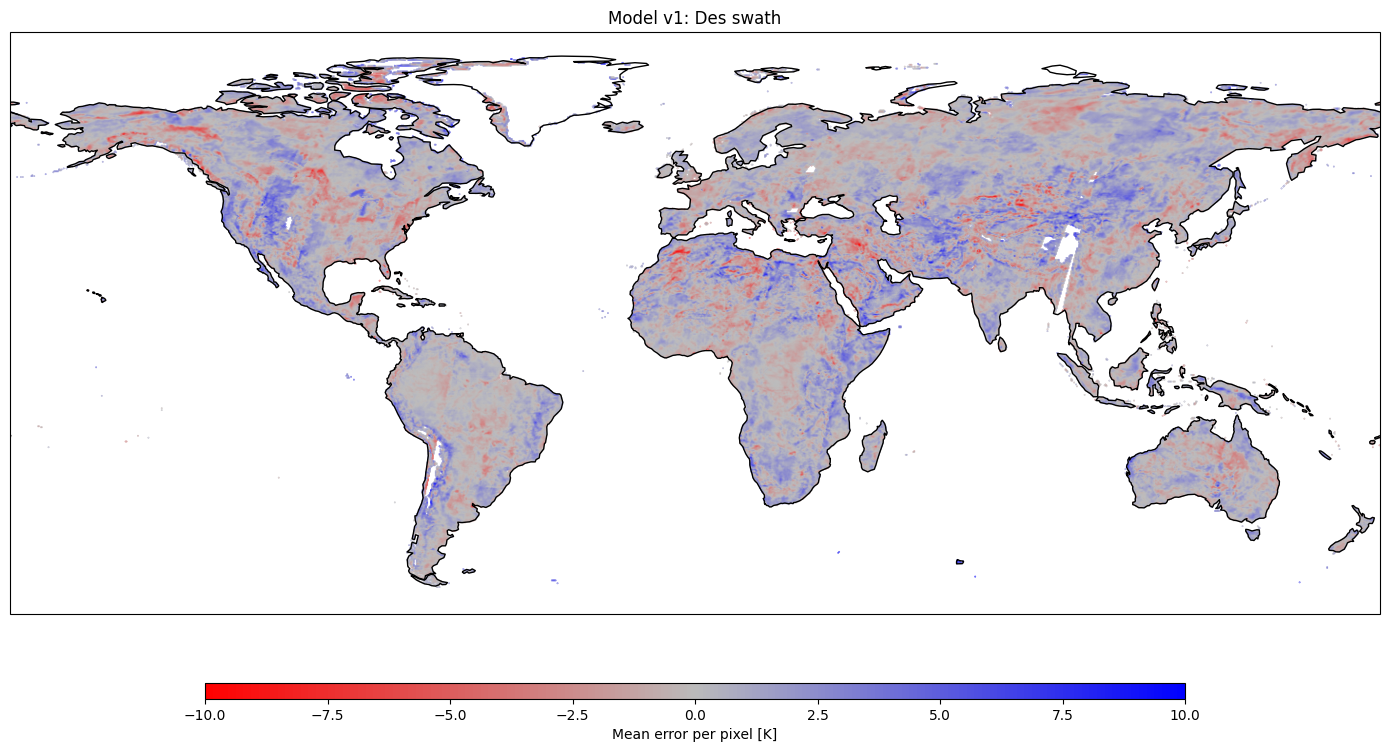

In [13]:
fig, ax, stats_df_des, importances_des = get_error_maps(swath = 1)

In [14]:
stats_df_des

,Swath,Model,Bias [K],std [K],rmse [K],ks_stat,p-value,n_obs
0,Des,Model v2,0.258346,2.303993,2.318431,0.033853,0.0,1289282


In [15]:
importances_df = pd.DataFrame.from_dict(importances_des, orient="index", columns=["importance [mse]"])
importances_df["importance % "] = 100 * importances_df["importance [mse]"] / importances_df["importance [mse]"].sum()
importances_df

,importance [mse],importance %
lat,0.798436,3.369481
lon,0.160639,0.677914
tbtoa_18Ghz_V,7.953440,33.564306
tbtoa_18Ghz_H,3.688405,15.565436
tbtoa_37Ghz_V,4.599838,19.411773
tbtoa_37Ghz_H,3.602926,15.204703
Emis19V,0.474228,2.001289
Emis19H,0.562576,2.374128
Emis37V,0.975393,4.116254
Emis37H,0.880244,3.714717
